In [228]:
!pip install pyhht
!pip install rarfile pyhht pyod -q

In [229]:
# Подключение библиотек
import os
import random
import matplotlib.pyplot as plt
import rarfile
import numpy as np
from pyod.models.knn import KNN
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
import pyhht.emd as emd

In [230]:
# Подключение диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [231]:
# Распаковка датасета
rar_path = "/content/drive/MyDrive/dataset.rar"
extract_folder = "/content/drive/MyDrive/IAD/dataset"
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(extract_folder)

In [232]:
# Cчитываем данные
for i in range(2, 3):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

signal = 2


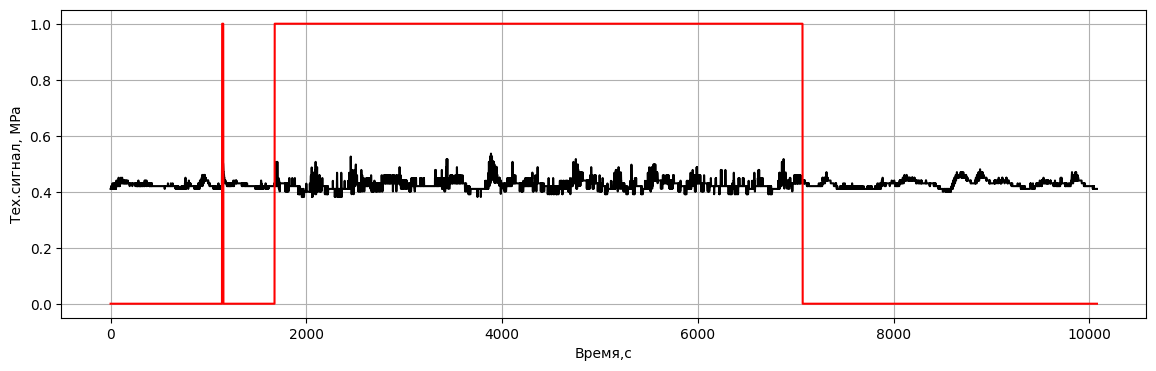

In [233]:
font= {'size'   : 10}
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests[0], color='black')
ax1.plot(X_masks[0], color='red')
ax1.set_xlabel('Время,с')
ax1.set_ylabel('Тех.сигнал, MPa')
plt.rc('font', **font)
ax1.grid(True)

Text(0.5, 1.0, 'Train Signal')

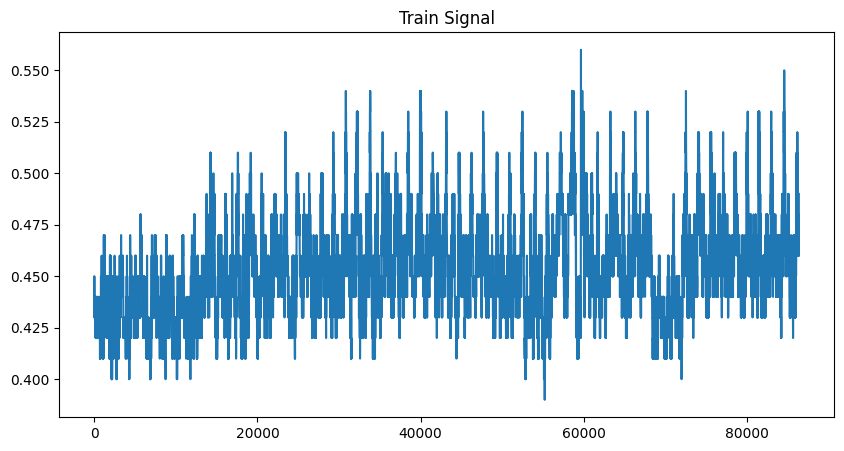

In [234]:
f, (ax1) = plt.subplots(1, figsize=(10, 5))
ax1.plot(X_train)
ax1.set_title('Train Signal')

In [235]:
# Размерность
print(X_train.shape, X_tests.shape, X_masks.shape)

(86400,) (10, 10080) (10, 10080)


In [236]:
# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

In [237]:
print("Размеры обучающих данных:", X_train.shape)
print("Размеры тестовых данных:", X_tests.shape)
print("Размеры маски аномалий:", X_masks.shape)

Размеры обучающих данных: (86400,)
Размеры тестовых данных: (100800, 1)
Размеры маски аномалий: (100800, 1)


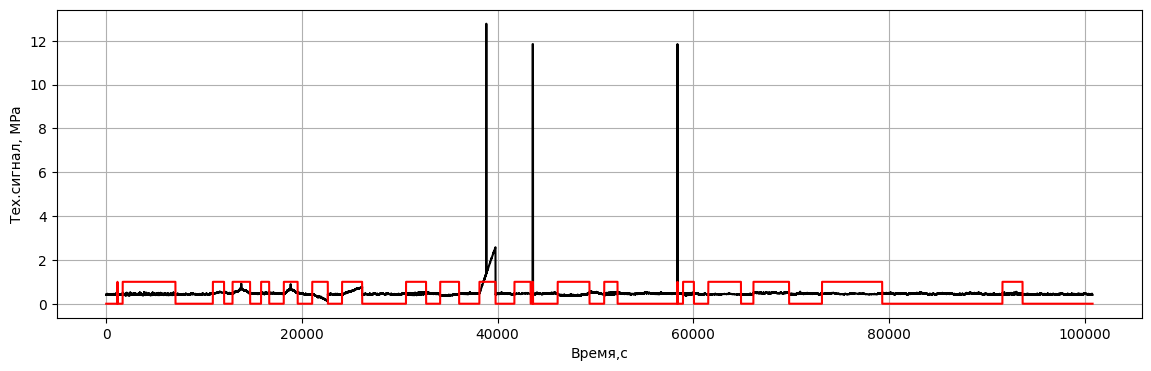

In [238]:
f, (ax1) = plt.subplots(1, figsize=(14, 4))
ax1.plot(X_tests, color='black')
ax1.plot(X_masks, color='red')
ax1.set_xlabel('Время,с')
ax1.set_ylabel('Тех.сигнал, MPa')
ax1.grid(True)

Под преобразованием Гильберта-Хуанга (Hilbert-Huang transform – HHT)  понимается метод эмпирической модовой декомпозиции (EMD) нелинейных и нестационарных процессов и Гильбертов спектральный анализ (HSA). HHT представляет собой частотно-временной анализ данных (сигналов) и не требует априорного функционального базиса преобразования.

In [239]:
from pyhht.emd import EMD
def hht(data, num_levels=3):
    emd = EMD(data)
    imfs = emd.decompose()[:num_levels]
    hht_result = np.cumsum(imfs, axis=0)
    return hht_result.T


In [240]:
num_levels = 3
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

Mode 1, Iteration 600
2 minima > 0; 20438 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 20513 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 20572 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 20601 maxima < 0.
Mode 1, Iteration 1400
0 minima > 0; 20626 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 20655 maxima < 0.
Mode 1, Iteration 1800
0 minima > 0; 20686 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
6 minima > 0; 23339 maxima < 0.
Mode 1, Iteration 800
6 minima > 0; 23422 maxima < 0.
Mode 1, Iteration 1000
7 minima > 0; 23474 maxima < 0.
Mode 1, Iteration 1200
5 minima > 0; 23524 maxima < 0.
Mode 1, Iteration 1400
4 minima > 0; 23567 maxima < 0.
Mode 1, Iteration 1600
1 minima > 0; 23599 maxima < 0.
Mode 1, Iteration 1800
1 minima > 0; 23628 maxima < 0.


In [241]:
def show_signal(data, count):
  fig, axs = plt.subplots(2, 2, figsize=(20, 18))
  fig.subplots_adjust(hspace=0.2, wspace=0.3)
  axs = axs.ravel()
  for i in range(count):
      plt.rcParams['axes.formatter.use_locale'] = True
      axs[i].plot(data[:, i])
      axs[i].set_ylabel(f"IMF {i + 1}", fontsize=12)
      axs[i].set_xlabel("$\it{N}$")
      axs[i].grid(True)
      plt.show

def show(n):
  f, (axs) = plt.subplots(1, figsize=(20, 8))
  f.subplots_adjust(hspace=0.2, wspace=0.3)
  axs.plot(predictions[:n], color="gray")
  axs.plot(X_masks.reshape(-1, 1)[:n], color="red", alpha=0.7)
  axs.plot(X_tests.reshape(-1, 1)[:n], color="black", alpha=0.7)
  axs.set_xlabel(f"Время, с")
  axs.set_ylabel("Тех. сигнал, MPa")
  axs.grid(True)
  plt.show

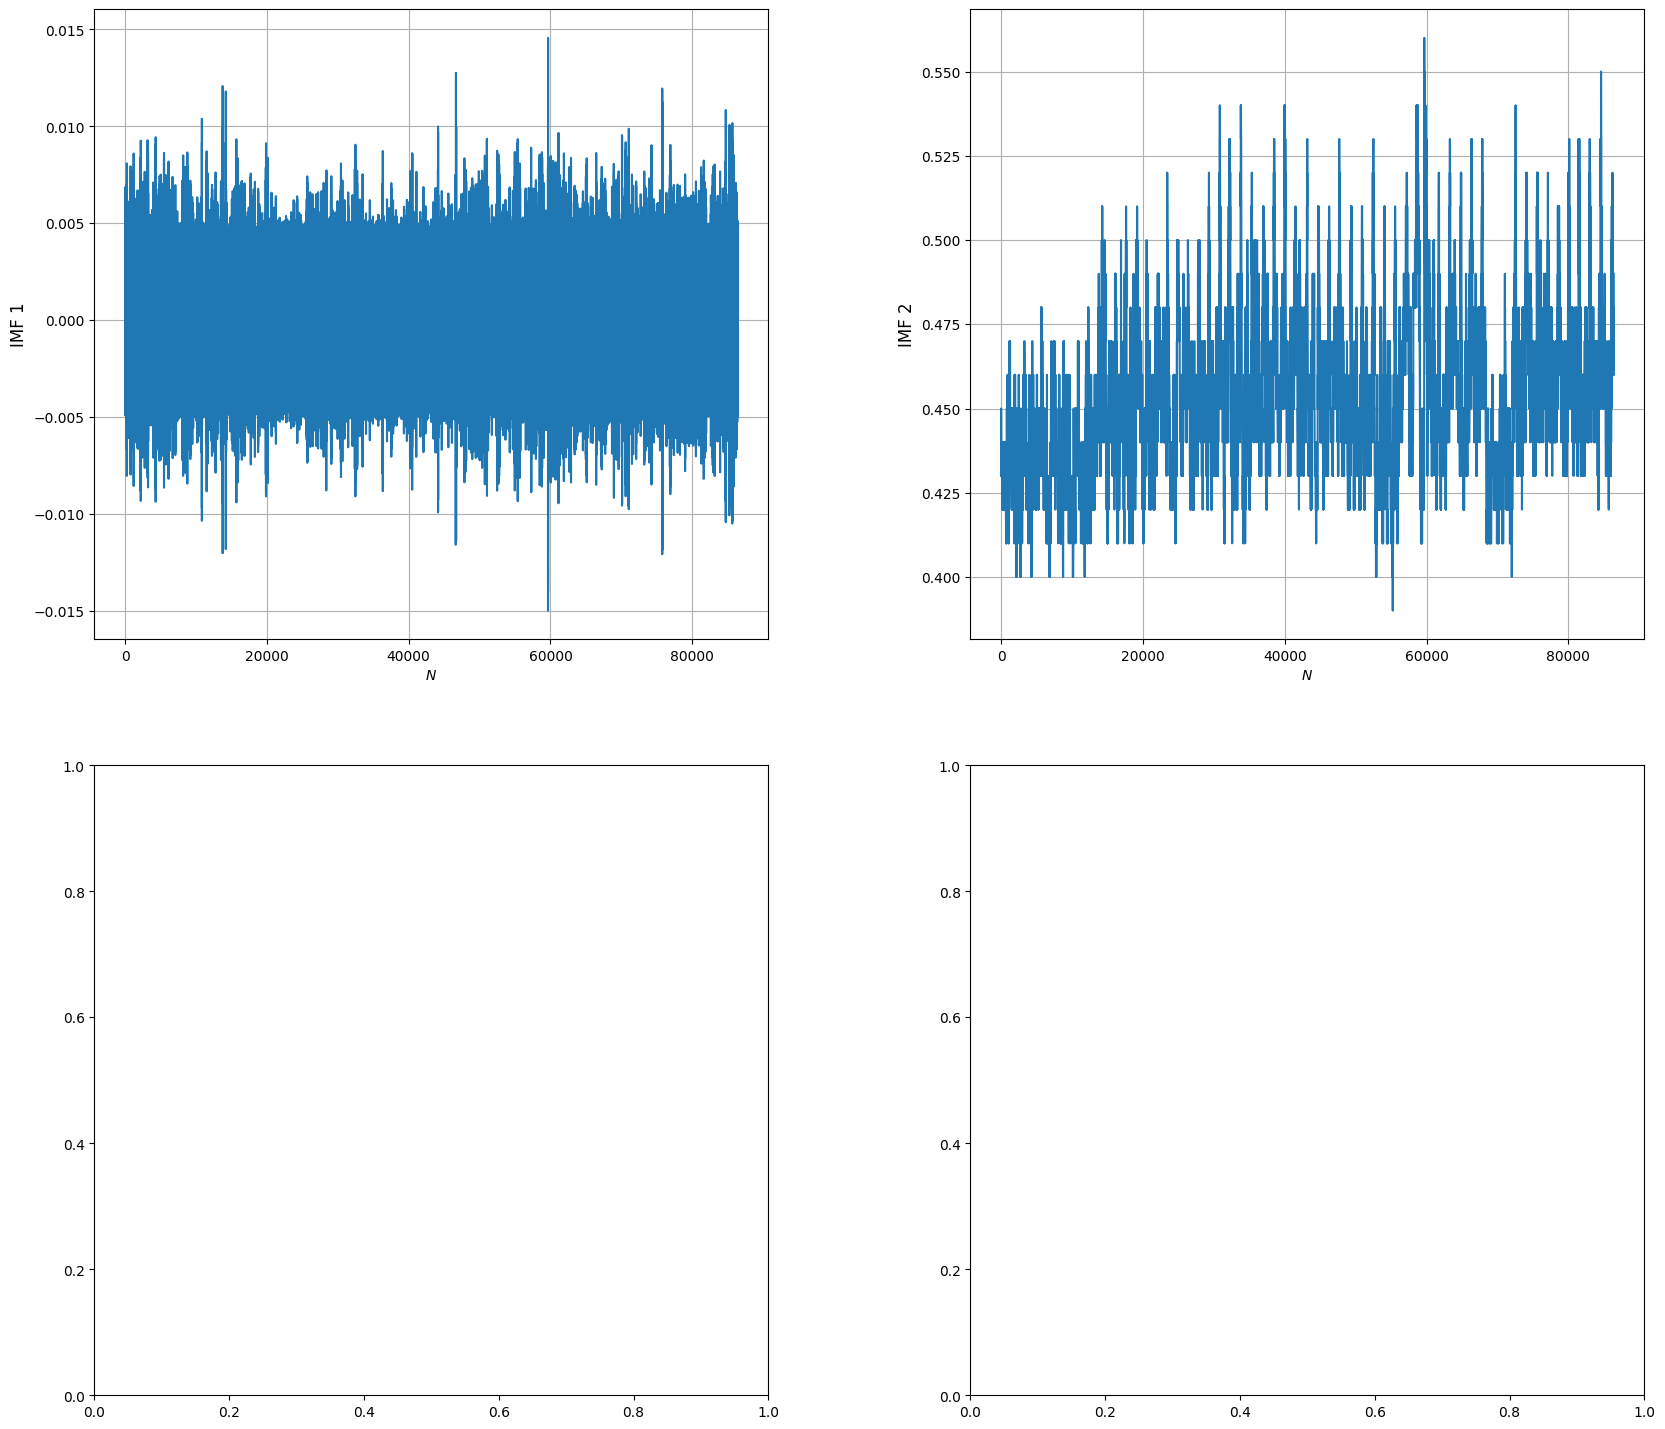

In [242]:
show_signal(train_hht, 2)

In [243]:
train_hht.shape, test_hht.shape

((86400, 2), (100800, 2))

In [244]:
models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

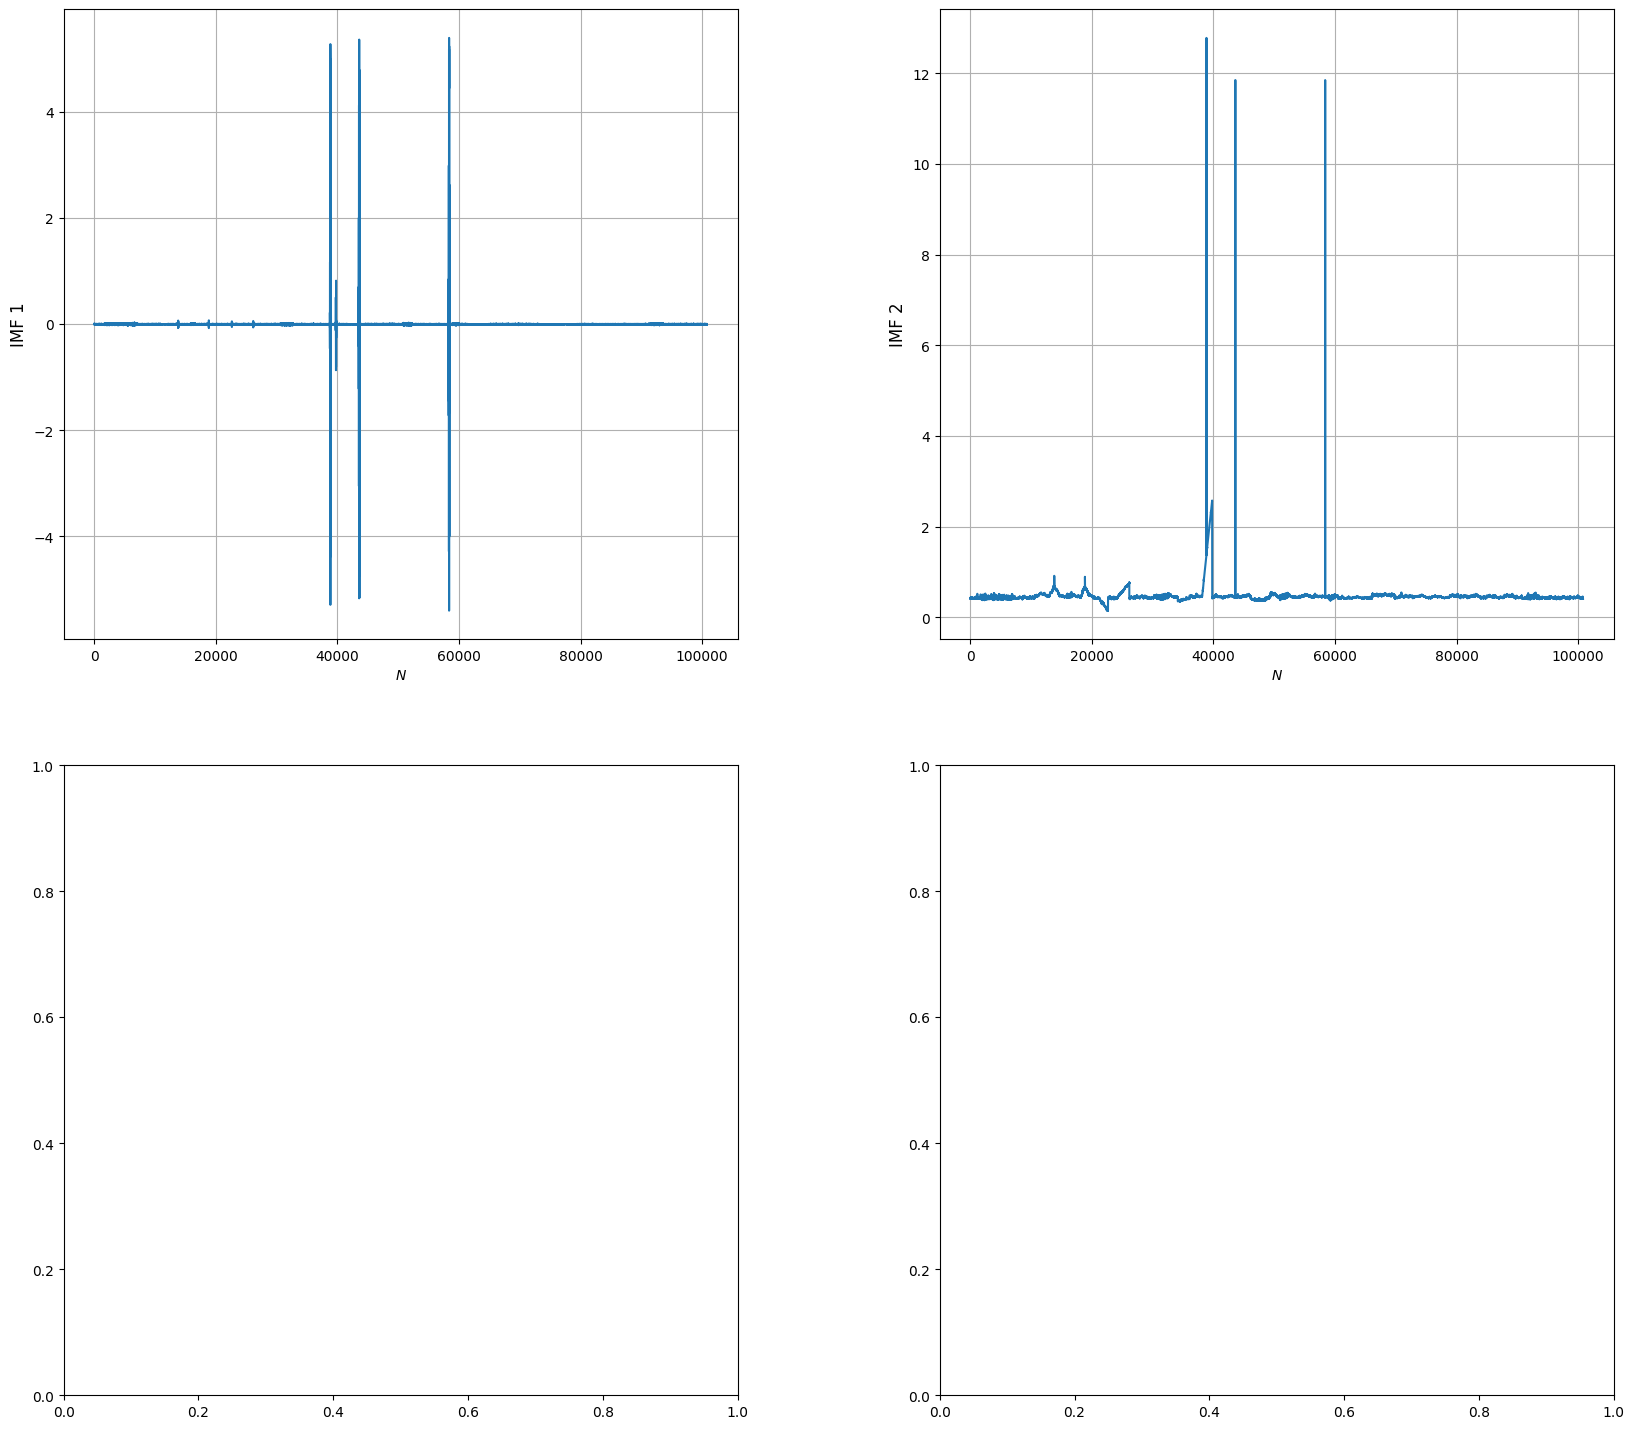

In [245]:
show_signal(test_hht, 2)

In [246]:
bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

In [247]:
# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.8651587301587301
Recall: 0.8403960171401044
F1-score: 0.8528013339372861


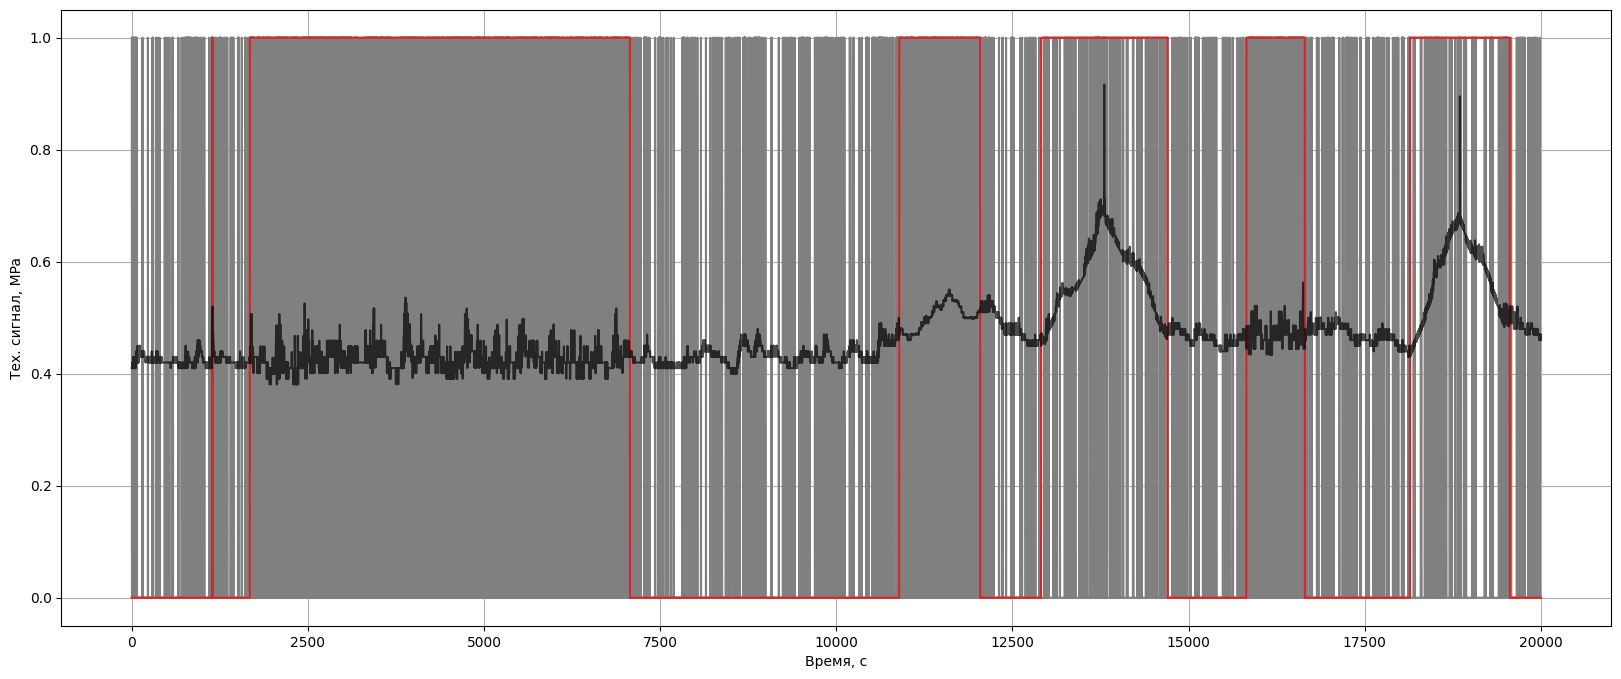

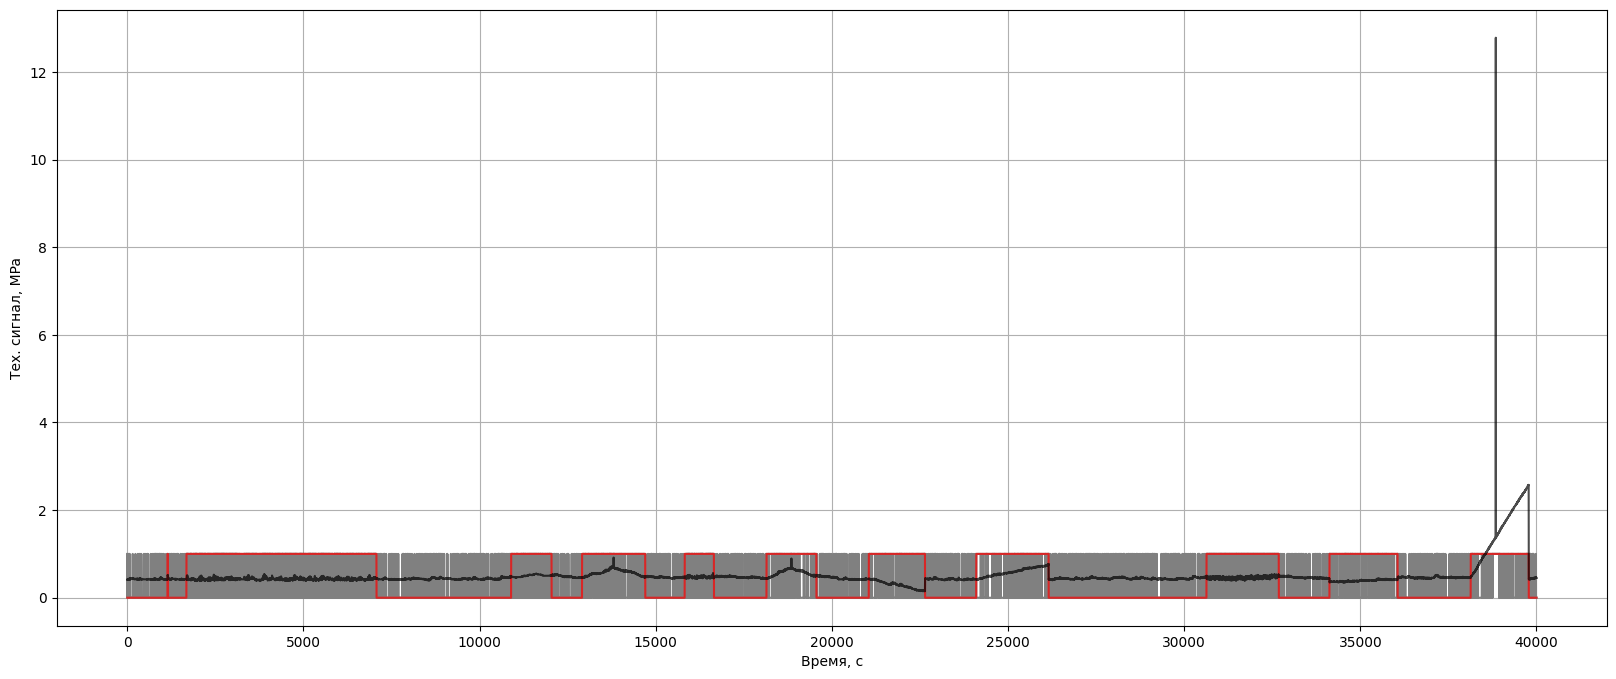

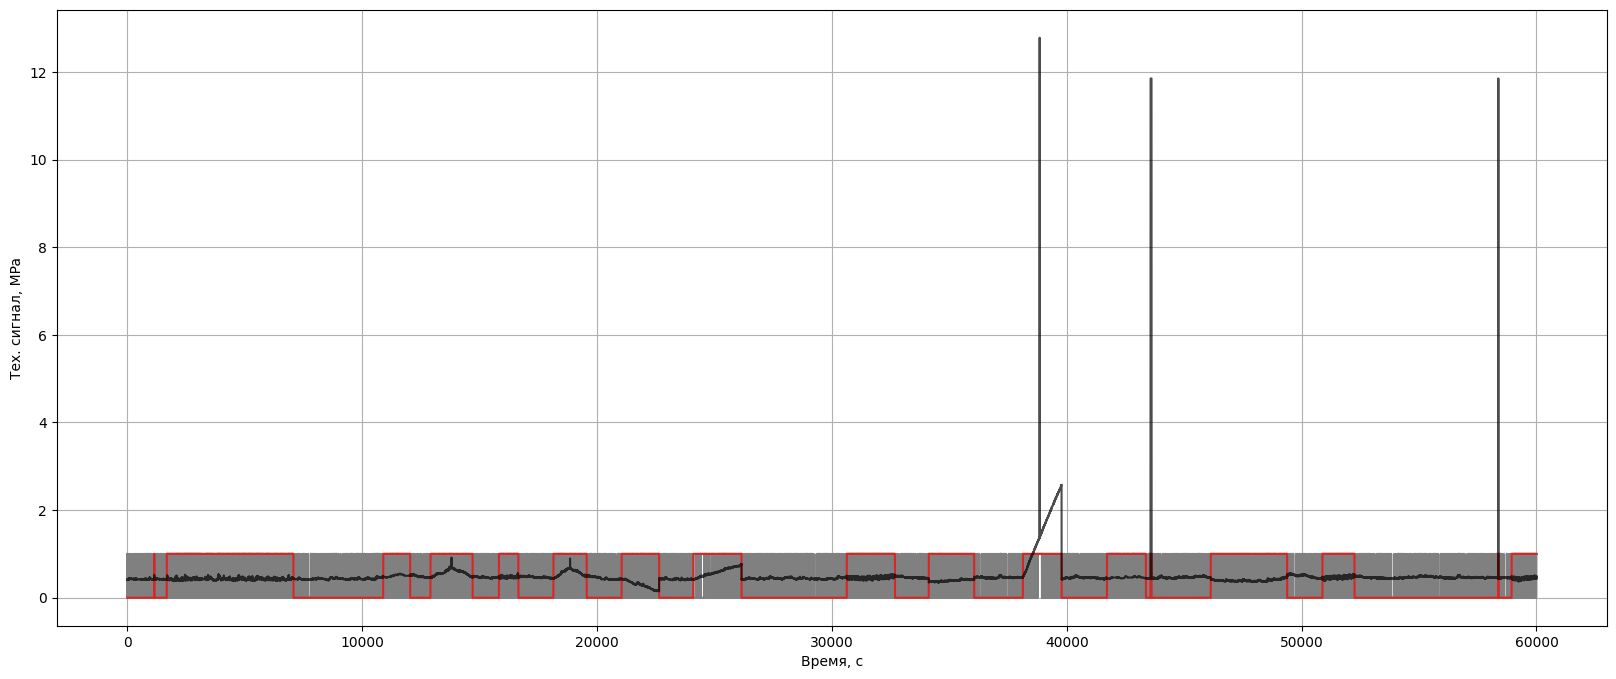

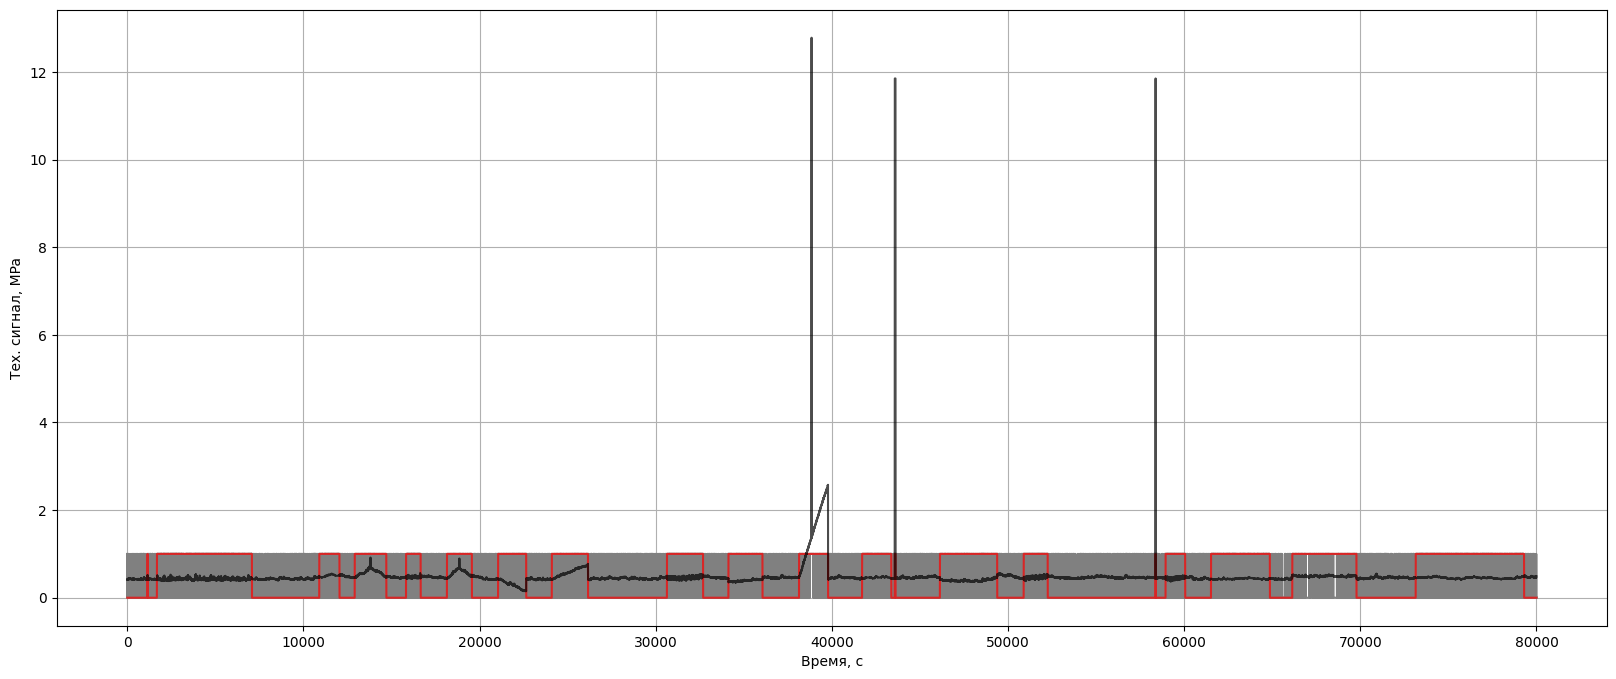

In [248]:
# Визуализируем
show(20000)
show(40000)
show(60000)
show(80000)

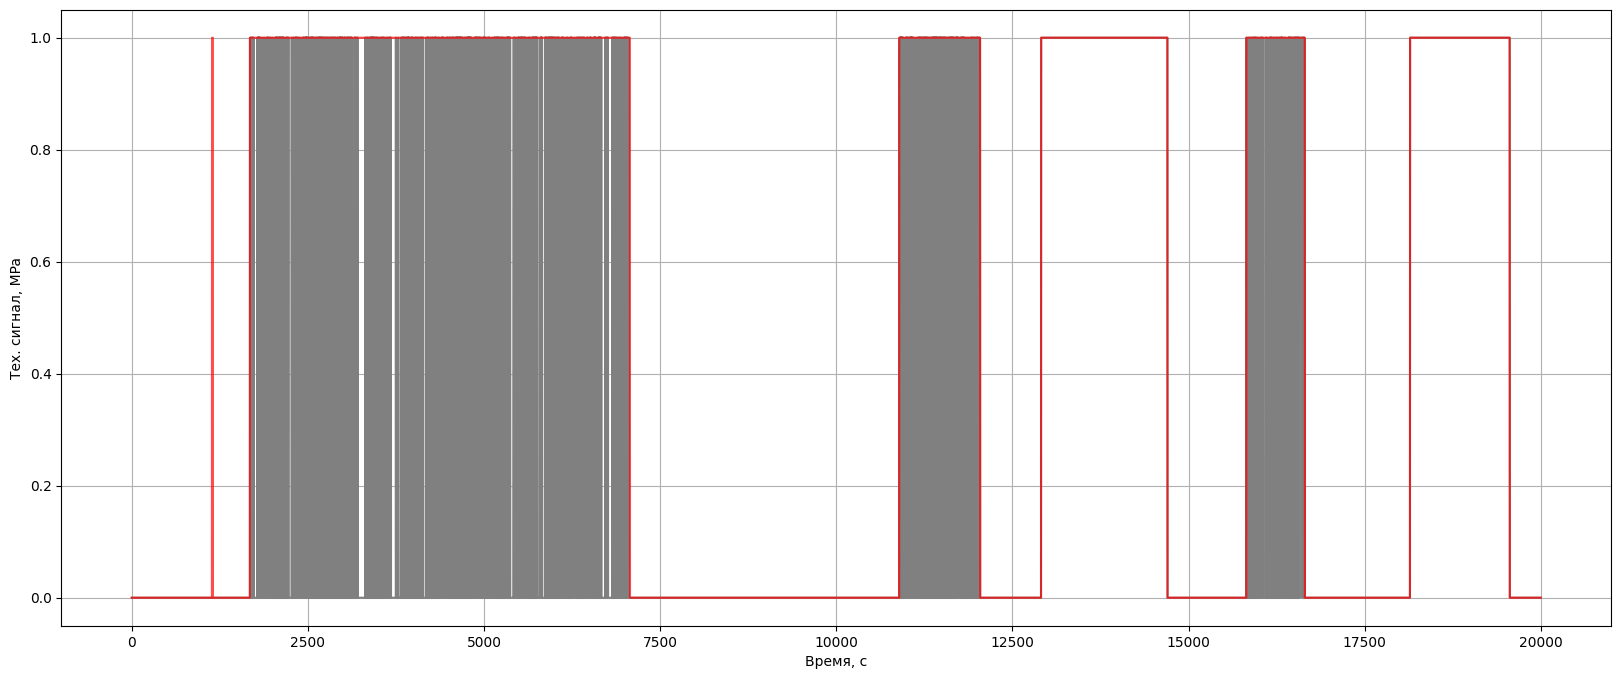

In [227]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [250]:
# Сигнал = 1

# Cчитываем данные
for i in range(1, 2):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 1
Mode 2, Iteration 600
1 minima > 0; 11840 maxima < 0.
Mode 2, Iteration 800
1 minima > 0; 11890 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 11943 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 7298 maxima < 0.
Mode 4, Iteration 1400
0 minima > 0; 4304 maxima < 0.
Mode 9, Iteration 1600
2 minima > 0; 172 maxima < 0.
Mode 13, Iteration 1800
0 minima > 0; 10 maxima < 0.
Mode 1, Iteration 600
0 minima > 0; 32965 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 33036 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 33114 maxima < 0.
Mode 2, Iteration 1200
19 minima > 0; 19935 maxima < 0.
Mode 2, Iteration 1400
7 minima > 0; 20257 maxima < 0.
Mode 2, Iteration 1600
1 minima > 0; 20374 maxima < 0.
Mode 2, Iteration 1800
3 minima > 0; 20478 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Accuracy: 0.7709722222222222
Recall: 0.6535831326566106
F1-score: 0.6694645586429806


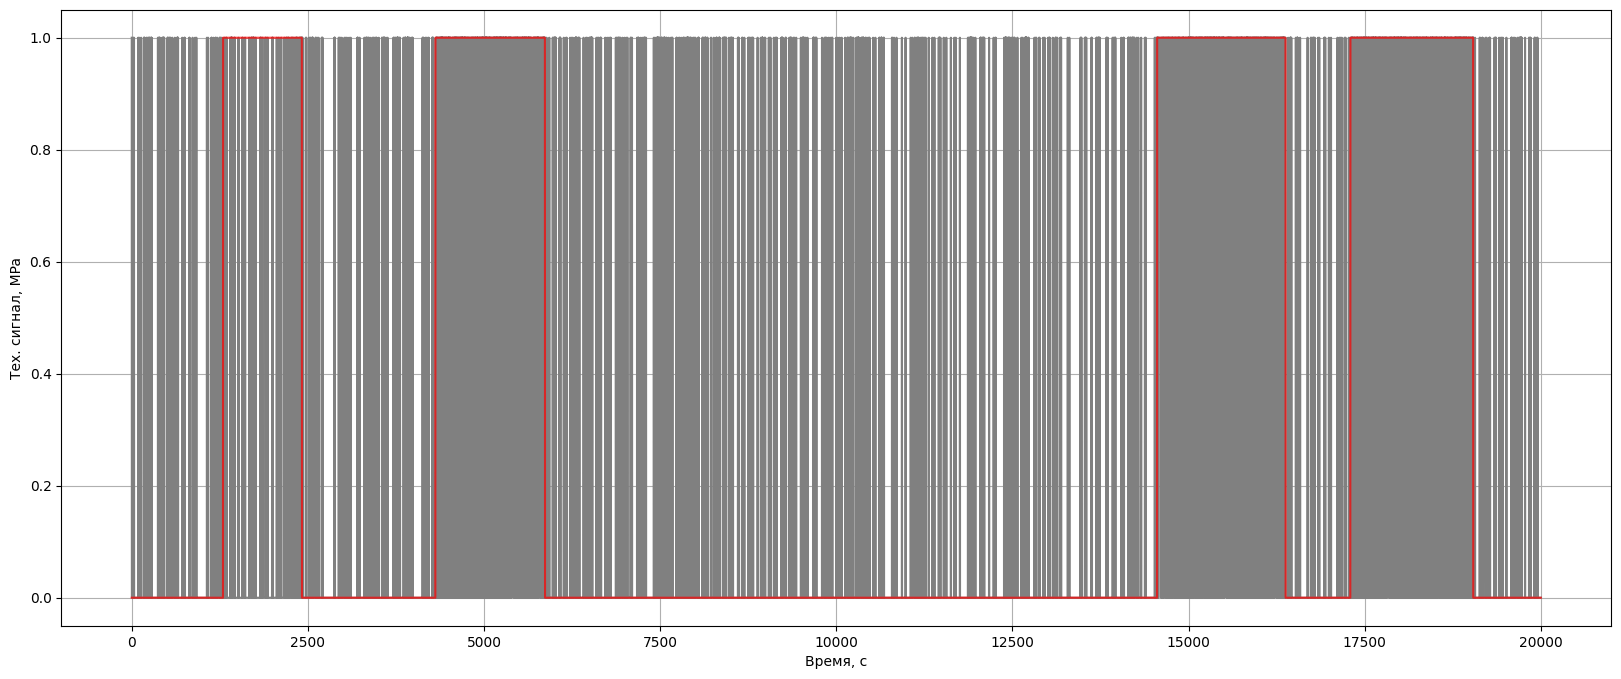

In [251]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [252]:
# Сигнал = 3

# Cчитываем данные
for i in range(3, 4):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 3
Mode 1, Iteration 600
1 minima > 0; 21985 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 22083 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 22176 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 22240 maxima < 0.
Mode 1, Iteration 1400
1 minima > 0; 22295 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 22336 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 22363 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 25303 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 25397 maxima < 0.
Mode 1, Iteration 1000
2 minima > 0; 25470 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 25529 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 25584 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 25619 maxima < 0.
Mode 1, Iteration 1800
2 minima > 0; 25638 maxima < 0.
Accuracy: 0.7738888888888888
Recall: 0.6627671151445238
F1-score: 0.678578475266245


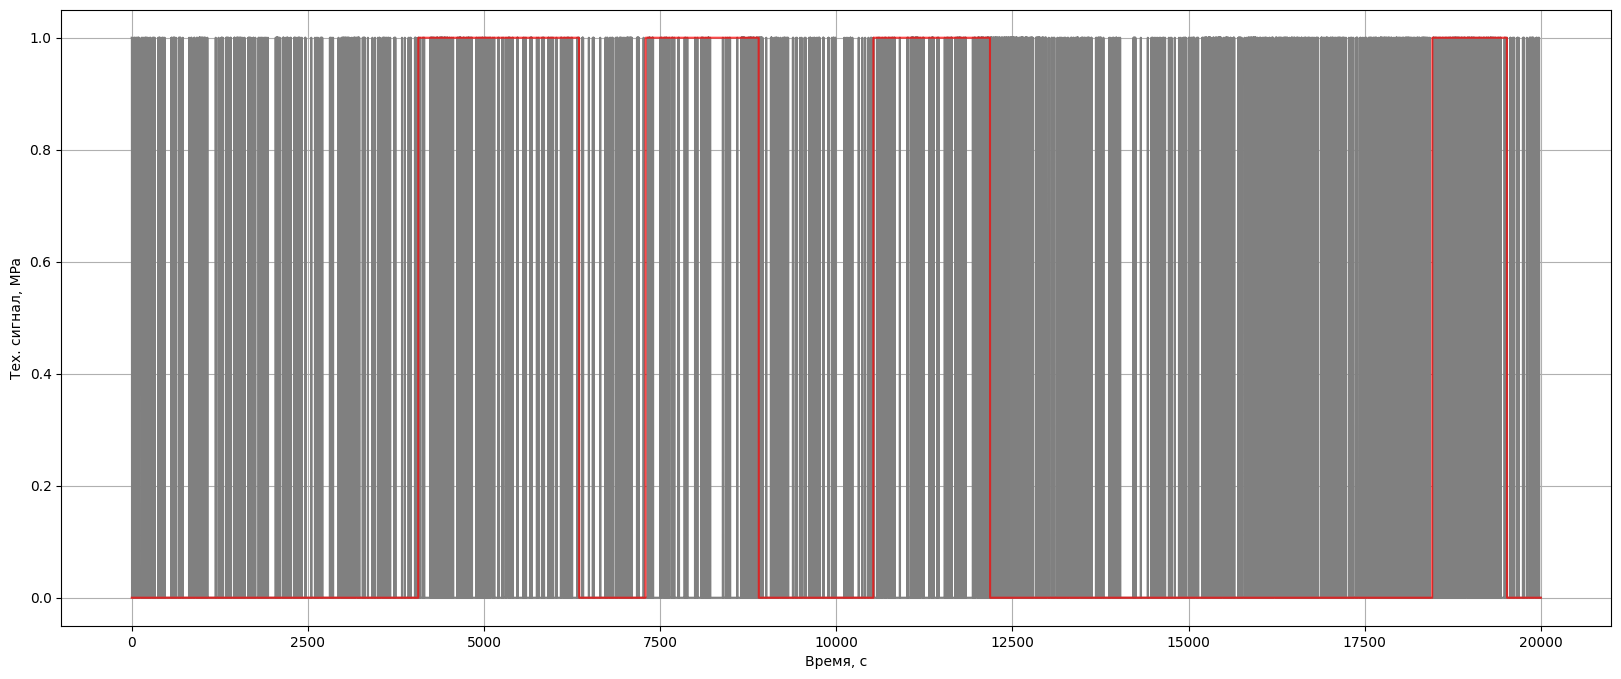

In [254]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [255]:
# Сигнал = 4

# Cчитываем данные
for i in range(4, 5):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 4
Mode 1, Iteration 600
0 minima > 0; 19084 maxima < 0.
Mode 2, Iteration 800
2 minima > 0; 8897 maxima < 0.
Mode 2, Iteration 1000
1 minima > 0; 8927 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 5753 maxima < 0.
Mode 5, Iteration 1400
1 minima > 0; 2027 maxima < 0.
Mode 14, Iteration 1600
0 minima > 0; 4 maxima < 0.
Mode 1, Iteration 600
0 minima > 0; 25298 maxima < 0.
Mode 2, Iteration 800
3 minima > 0; 12330 maxima < 0.
Mode 2, Iteration 1000
3 minima > 0; 12615 maxima < 0.
Mode 2, Iteration 1200
0 minima > 0; 12730 maxima < 0.
Mode 3, Iteration 1400
4 minima > 0; 7954 maxima < 0.
Mode 3, Iteration 1600
3 minima > 0; 8096 maxima < 0.
Mode 3, Iteration 1800
2 minima > 0; 8165 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Accuracy: 0.7553769841269842
Recall: 0.7248087308912543
F1-score: 0.7313939175130991


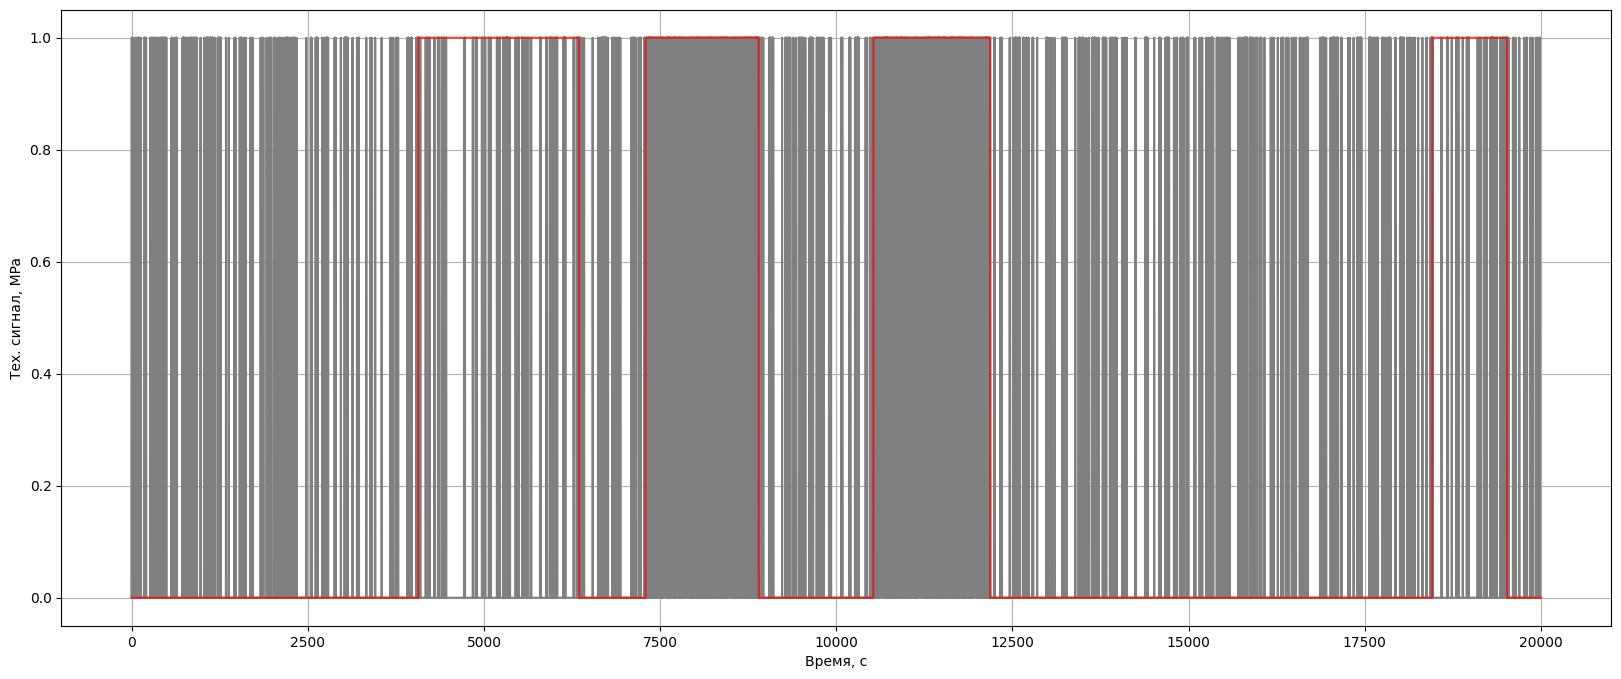

In [256]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [257]:
# Сигнал = 5

# Cчитываем данные
for i in range(5, 6):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 5
Mode 1, Iteration 600
1 minima > 0; 23871 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 23981 maxima < 0.
Mode 2, Iteration 1000
7 minima > 0; 13725 maxima < 0.
Mode 2, Iteration 1200
3 minima > 0; 13894 maxima < 0.
Mode 2, Iteration 1400
3 minima > 0; 13989 maxima < 0.
Mode 2, Iteration 1600
2 minima > 0; 14059 maxima < 0.
Mode 2, Iteration 1800
1 minima > 0; 14116 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 24129 maxima < 0.
Mode 1, Iteration 800
1 minima > 0; 24247 maxima < 0.
Mode 1, Iteration 1000
0 minima > 0; 24338 maxima < 0.
Mode 1, Iteration 1200
2 minima > 0; 24411 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 24462 maxima < 0.
Mode 1, Iteration 1600
0 minima > 0; 24517 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 24560 maxima < 0.
Accuracy: 0.7045833333333333
Recall: 0.5732853427223765
F1-score: 0.5628058192784217


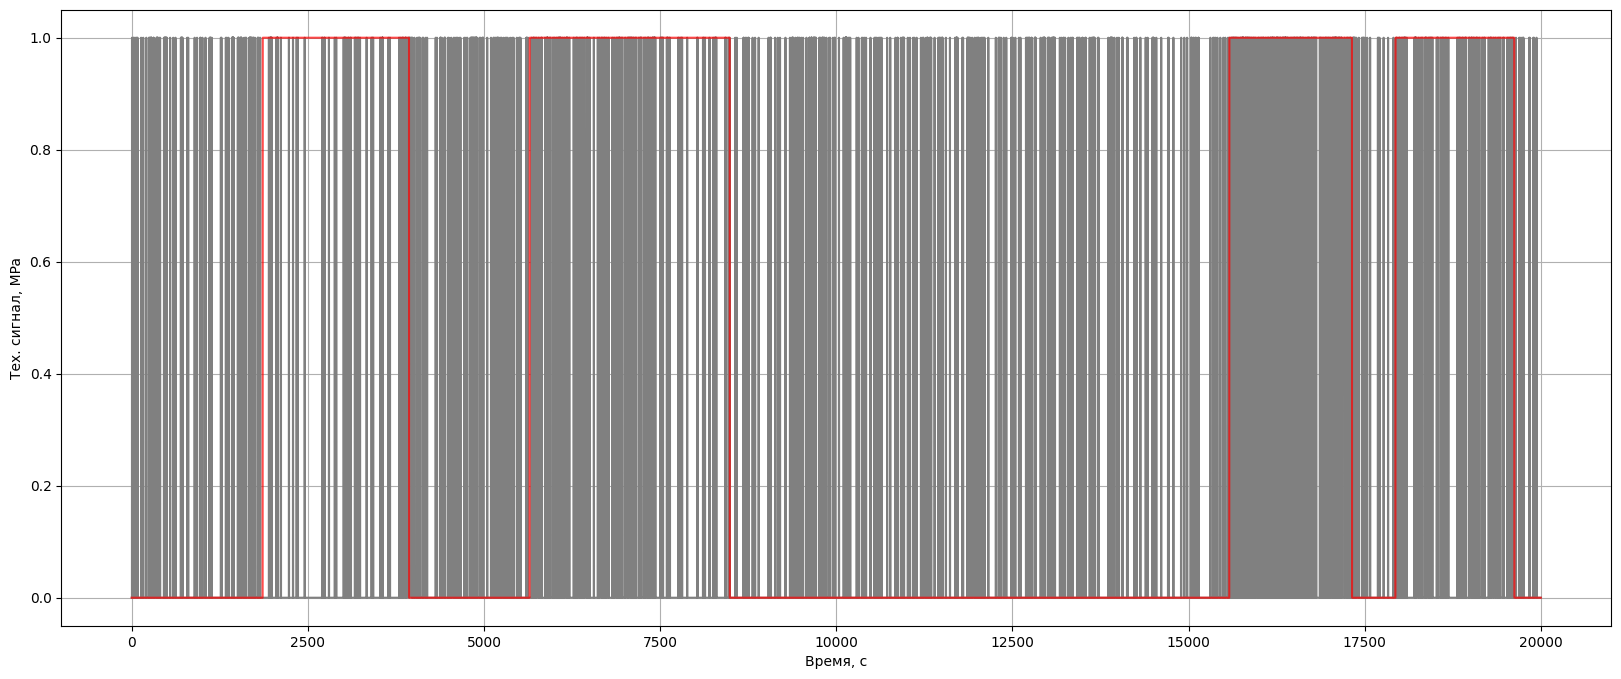

In [258]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [259]:
# Сигнал = 6

# Cчитываем данные
for i in range(6, 7):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 6
Mode 5, Iteration 600
2689 minima > 0; 0 maxima < 0.
Mode 5, Iteration 800
0 minima > 0; 3253 maxima < 0.
Mode 6, Iteration 1000
2 minima > 0; 1904 maxima < 0.
Mode 11, Iteration 1200
1 minima > 0; 66 maxima < 0.
Mode 1, Iteration 600
5 minima > 0; 33373 maxima < 0.
Mode 1, Iteration 800
5 minima > 0; 33497 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 33576 maxima < 0.
Mode 1, Iteration 1200
5 minima > 0; 33644 maxima < 0.
Mode 1, Iteration 1400
2 minima > 0; 33693 maxima < 0.
Mode 1, Iteration 1600
5 minima > 0; 33754 maxima < 0.
Mode 1, Iteration 1800
4 minima > 0; 33798 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Accuracy: 0.7460714285714286
Recall: 0.6111021504515112
F1-score: 0.6148679500535333


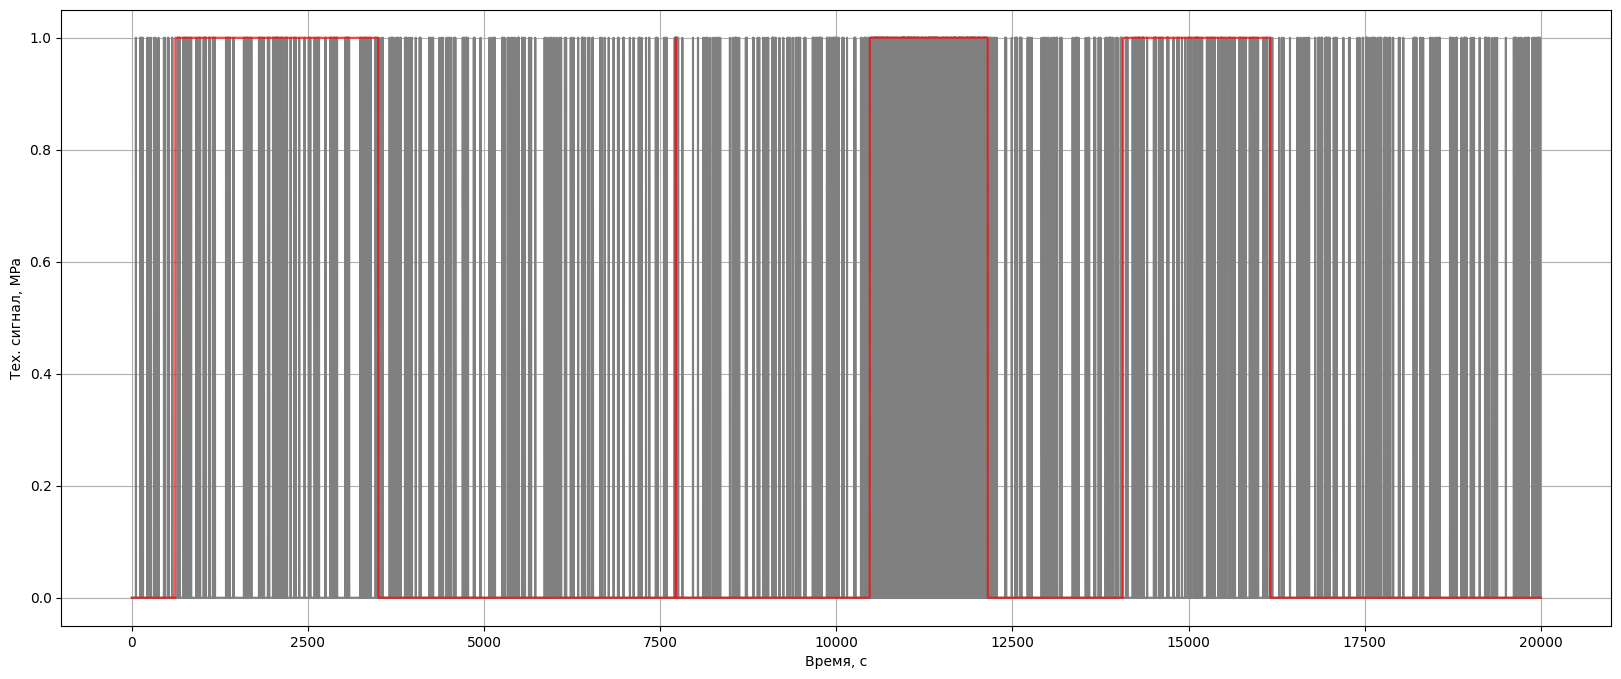

In [260]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [261]:
# Сигнал = 7

# Cчитываем данные
for i in range(7, 8):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 7
Mode 1, Iteration 600
8 minima > 0; 26361 maxima < 0.
Mode 1, Iteration 800
4 minima > 0; 26448 maxima < 0.
Mode 1, Iteration 1000
5 minima > 0; 26523 maxima < 0.
Mode 1, Iteration 1200
3 minima > 0; 26593 maxima < 0.
Mode 1, Iteration 1400
3 minima > 0; 26634 maxima < 0.
Mode 1, Iteration 1600
2 minima > 0; 26682 maxima < 0.
Mode 1, Iteration 1800
1 minima > 0; 26712 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
25 minima > 0; 20263 maxima < 0.
Mode 1, Iteration 800
13 minima > 0; 20429 maxima < 0.
Mode 1, Iteration 1000
7 minima > 0; 20533 maxima < 0.
Mode 1, Iteration 1200
8 minima > 0; 20604 maxima < 0.
Mode 1, Iteration 1400
5 minima > 0; 20668 maxima < 0.
Mode 1, Iteration 1600
10 minima > 0; 20711 maxima < 0.
Mode 1, Iteration 1800
11 minima > 0; 20768 maxima < 0.
Accuracy: 0.6455357142857143
Recall: 0.5192325662022336
F1-score: 0.4495396435081113


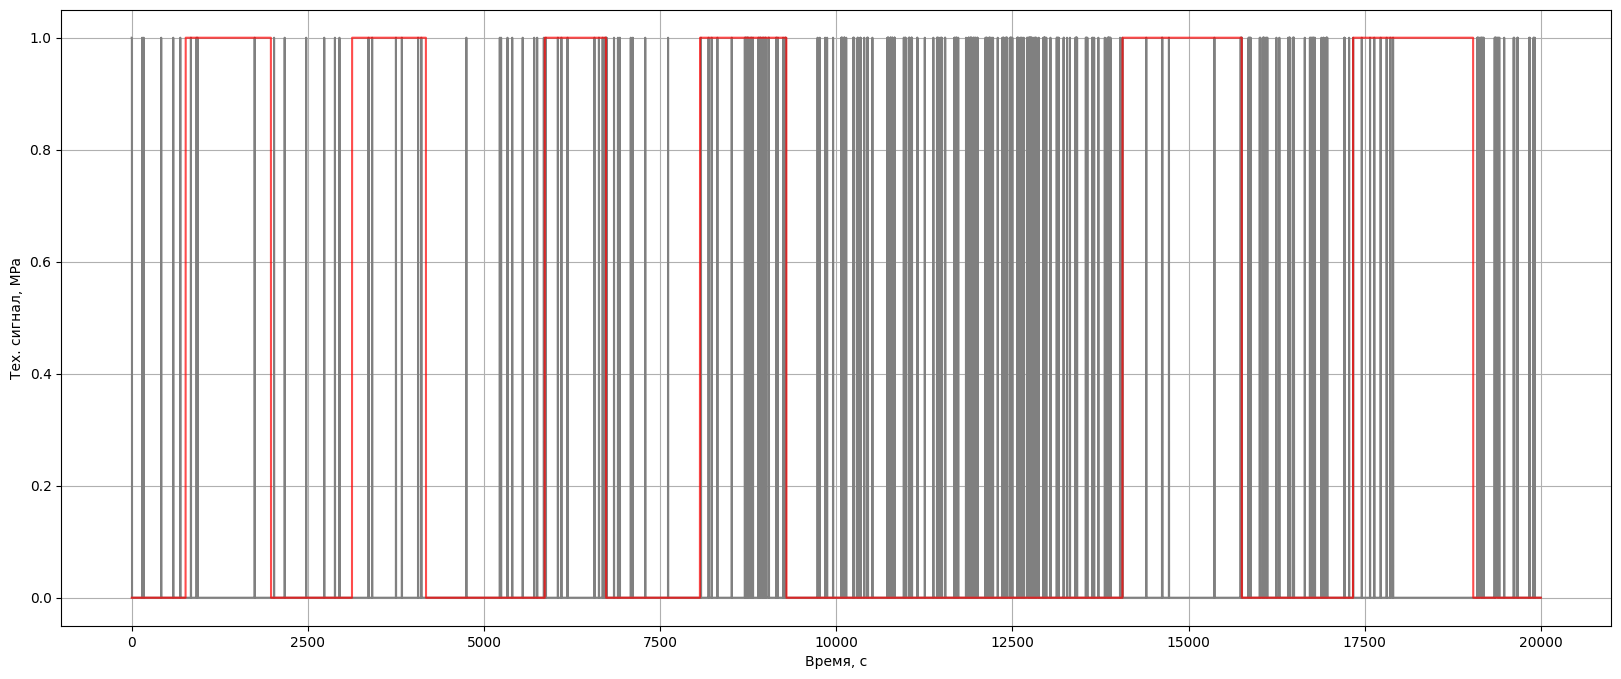

In [262]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [263]:
# Сигнал = 8

# Cчитываем данные
for i in range(8, 9):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 8
Mode 1, Iteration 600
2 minima > 0; 27702 maxima < 0.
Mode 1, Iteration 800
0 minima > 0; 27824 maxima < 0.
Mode 1, Iteration 1000
0 minima > 0; 27939 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 28035 maxima < 0.
Mode 2, Iteration 1400
2 minima > 0; 16104 maxima < 0.
Mode 3, Iteration 1600
11 minima > 0; 9425 maxima < 0.
Mode 4, Iteration 1800
3 minima > 0; 5778 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 1, Iteration 600
1 minima > 0; 31363 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 31566 maxima < 0.
Mode 1, Iteration 1000
1 minima > 0; 31665 maxima < 0.
Mode 1, Iteration 1200
1 minima > 0; 31756 maxima < 0.
Mode 1, Iteration 1400
1 minima > 0; 31847 maxima < 0.
Mode 1, Iteration 1600
2 minima > 0; 31906 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 31957 maxima < 0.
Accuracy: 0.7504761904761905
Recall: 0.6955000048222221
F1-score: 0.7043633891861729


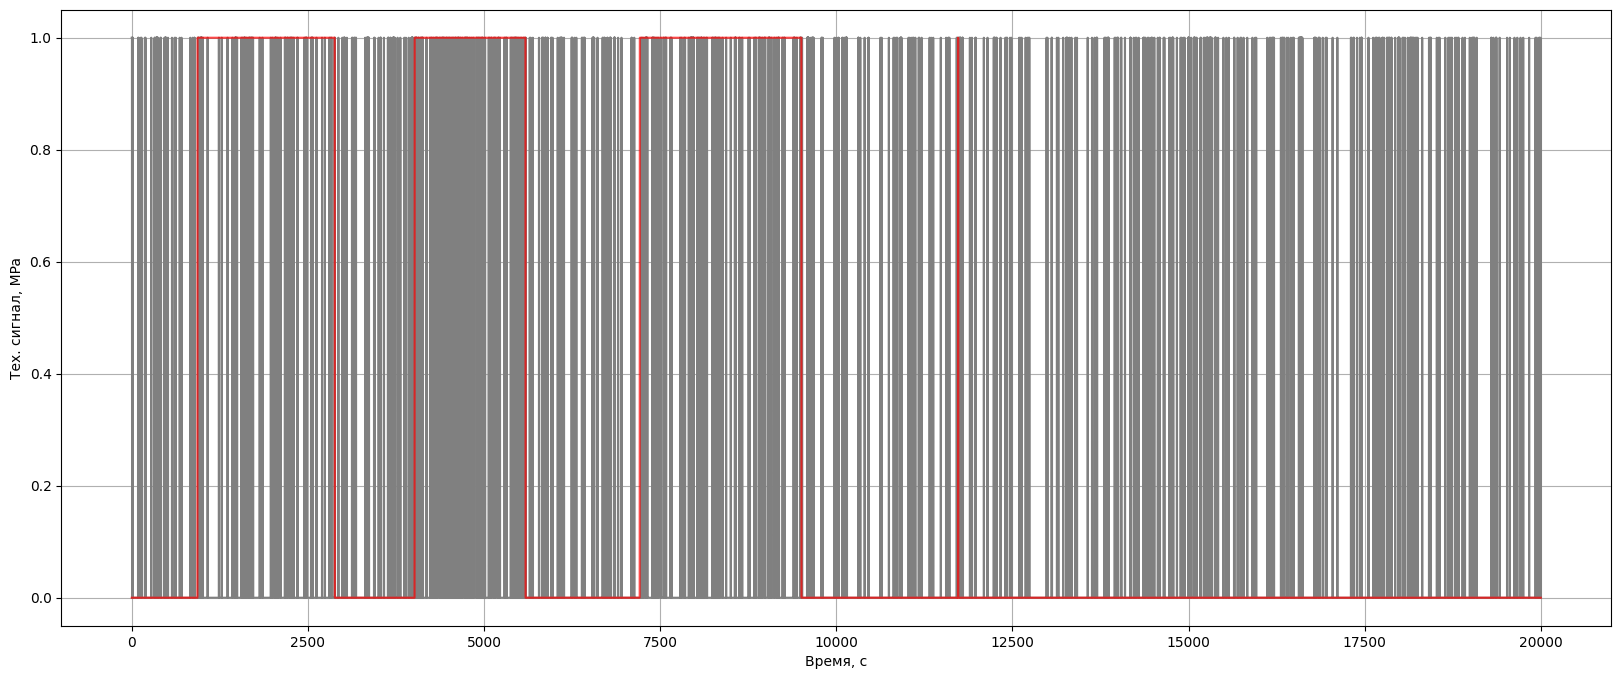

In [264]:
f, (ax1) = plt.subplots(1, figsize=(20, 8))
ax1.plot(pred[:20000], color="gray")
ax1.plot(X_masks.reshape(-1, 1)[:20000], color="red", alpha=0.7)
ax1.set_xlabel("Время, с")
ax1.set_ylabel("Тех. сигнал, MPa")
ax1.grid(True)

In [265]:
# Сигнал = 9

# Cчитываем данные
for i in range(9, 10):
    print(f"signal = {i}")
    X_train = np.load(f"/content/drive/MyDrive/IAD/train/train{i}.npy")
    X_tests = np.load(f"/content/drive/MyDrive/IAD/test/test{i}.npy")
    X_masks = np.load(f"/content/drive/MyDrive/IAD/mask/mask{i}.npy")

# Склеивание теста и масок в один сигнал
X_tests = X_tests.reshape(-1, 1)
X_masks = X_masks.reshape(-1, 1)

num_levels = 5
train_hht = hht(X_train, num_levels)
test_hht = hht(X_tests, num_levels)

models = []

# Для случая, когда размерности IMFs в train_hht и test_hht различаются
shape = min(train_hht.shape[1], test_hht.shape[1])

# Обучение модели KNN
for i in range(shape):
    model_knn = KNN().fit(train_hht[:, i].reshape(-1, 1))
    models.append(model_knn)

# Выполним предсказание
predictions = np.zeros((len(test_hht), len(models)))

for i, model in enumerate(models):
    predictions[:, i] = model.predict(test_hht[:, i].reshape(-1, 1))

bagging_model = BaggingClassifier(base_estimator=None, n_estimators=num_levels, random_state=42)
bagging_model.fit(predictions, np.ravel(X_masks))
pred = bagging_model.predict(predictions)

# Метрики модели
accuracy = accuracy_score(np.ravel(X_masks), pred)
recall = recall_score(np.ravel(X_masks), pred, average='macro', zero_division=0)
f1 = f1_score(np.ravel(X_masks), pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


signal = 9
Mode 2, Iteration 600
0 minima > 0; 13163 maxima < 0.
Mode 2, Iteration 800
0 minima > 0; 13282 maxima < 0.
Mode 3, Iteration 1000
159 minima > 0; 7902 maxima < 0.
Mode 4, Iteration 1200
2 minima > 0; 5166 maxima < 0.
Mode 9, Iteration 1400
1 minima > 0; 195 maxima < 0.
Mode 1, Iteration 600
3 minima > 0; 27090 maxima < 0.
Mode 1, Iteration 800
3 minima > 0; 27283 maxima < 0.
Mode 1, Iteration 1000
4 minima > 0; 27433 maxima < 0.
Mode 1, Iteration 1200
0 minima > 0; 27547 maxima < 0.
Mode 1, Iteration 1400
3 minima > 0; 27653 maxima < 0.
Mode 1, Iteration 1600
1 minima > 0; 27747 maxima < 0.
Mode 1, Iteration 1800
3 minima > 0; 27825 maxima < 0.


/usr/local/lib/python3.10/dist-packages/pyhht/emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Accuracy: 0.6831845238095238
Recall: 0.5000866650019614
F1-score: 0.4060692278363107


Для каждого файла train соотвествует test из 10 сэмплов. В файле mask лежат метки значений 0 - нормальное значение, 1 - аномалия.

Предполагаю, что из-за наличия выбросов в наборе данных метрики модели не имеют высоких значений.

Если говорить о лучших показателях, то самые лучшие показатели у самой первой модели (сигнал 2) из рассмотренных:

1. **Accuracy**: 0.8651587301587301
2. **Recall**: 0.8403960171401044
3. **F1-score**: 0.8528013339372861

**Accuracy** — это показатель, который описывает общую точность предсказания модели по всем классам.


**Recall** (полнота) — это доля истинно положительных результатов. Эта метрика измеряет, как часто модель точно спрогнозировала истинный результат, когда результат на самом деле является истинным, т. е. насколько точно модель нашла все фактически истинные значения в наборе данных.

**Оценка F1** — это среднее гармоническое значение точности и полноты. Это хорошая сбалансированная мера как ложноположительных, так и ложноотрицательных результатов.

Использование бэггинга позволило незначительно увеличить метрики модели.